# Обратная связь



Но надеюсь, все нормально. Если что-то не понятно, пишите в личку/гуглите (последний вариант никогда вас не подведет)

# Домашки


## Высокоуровнкевые фреймворки

https://catalyst-team.github.io/catalyst/

https://github.com/pytorch/ignite

https://github.com/PyTorchLightning/pytorch-lightning

https://huggingface.co/docs/accelerate/index


 **Важно**: аккуратнее в сложных задачах, во фреймворках могут быть баги (особенно в новых!)



# Задачи CV

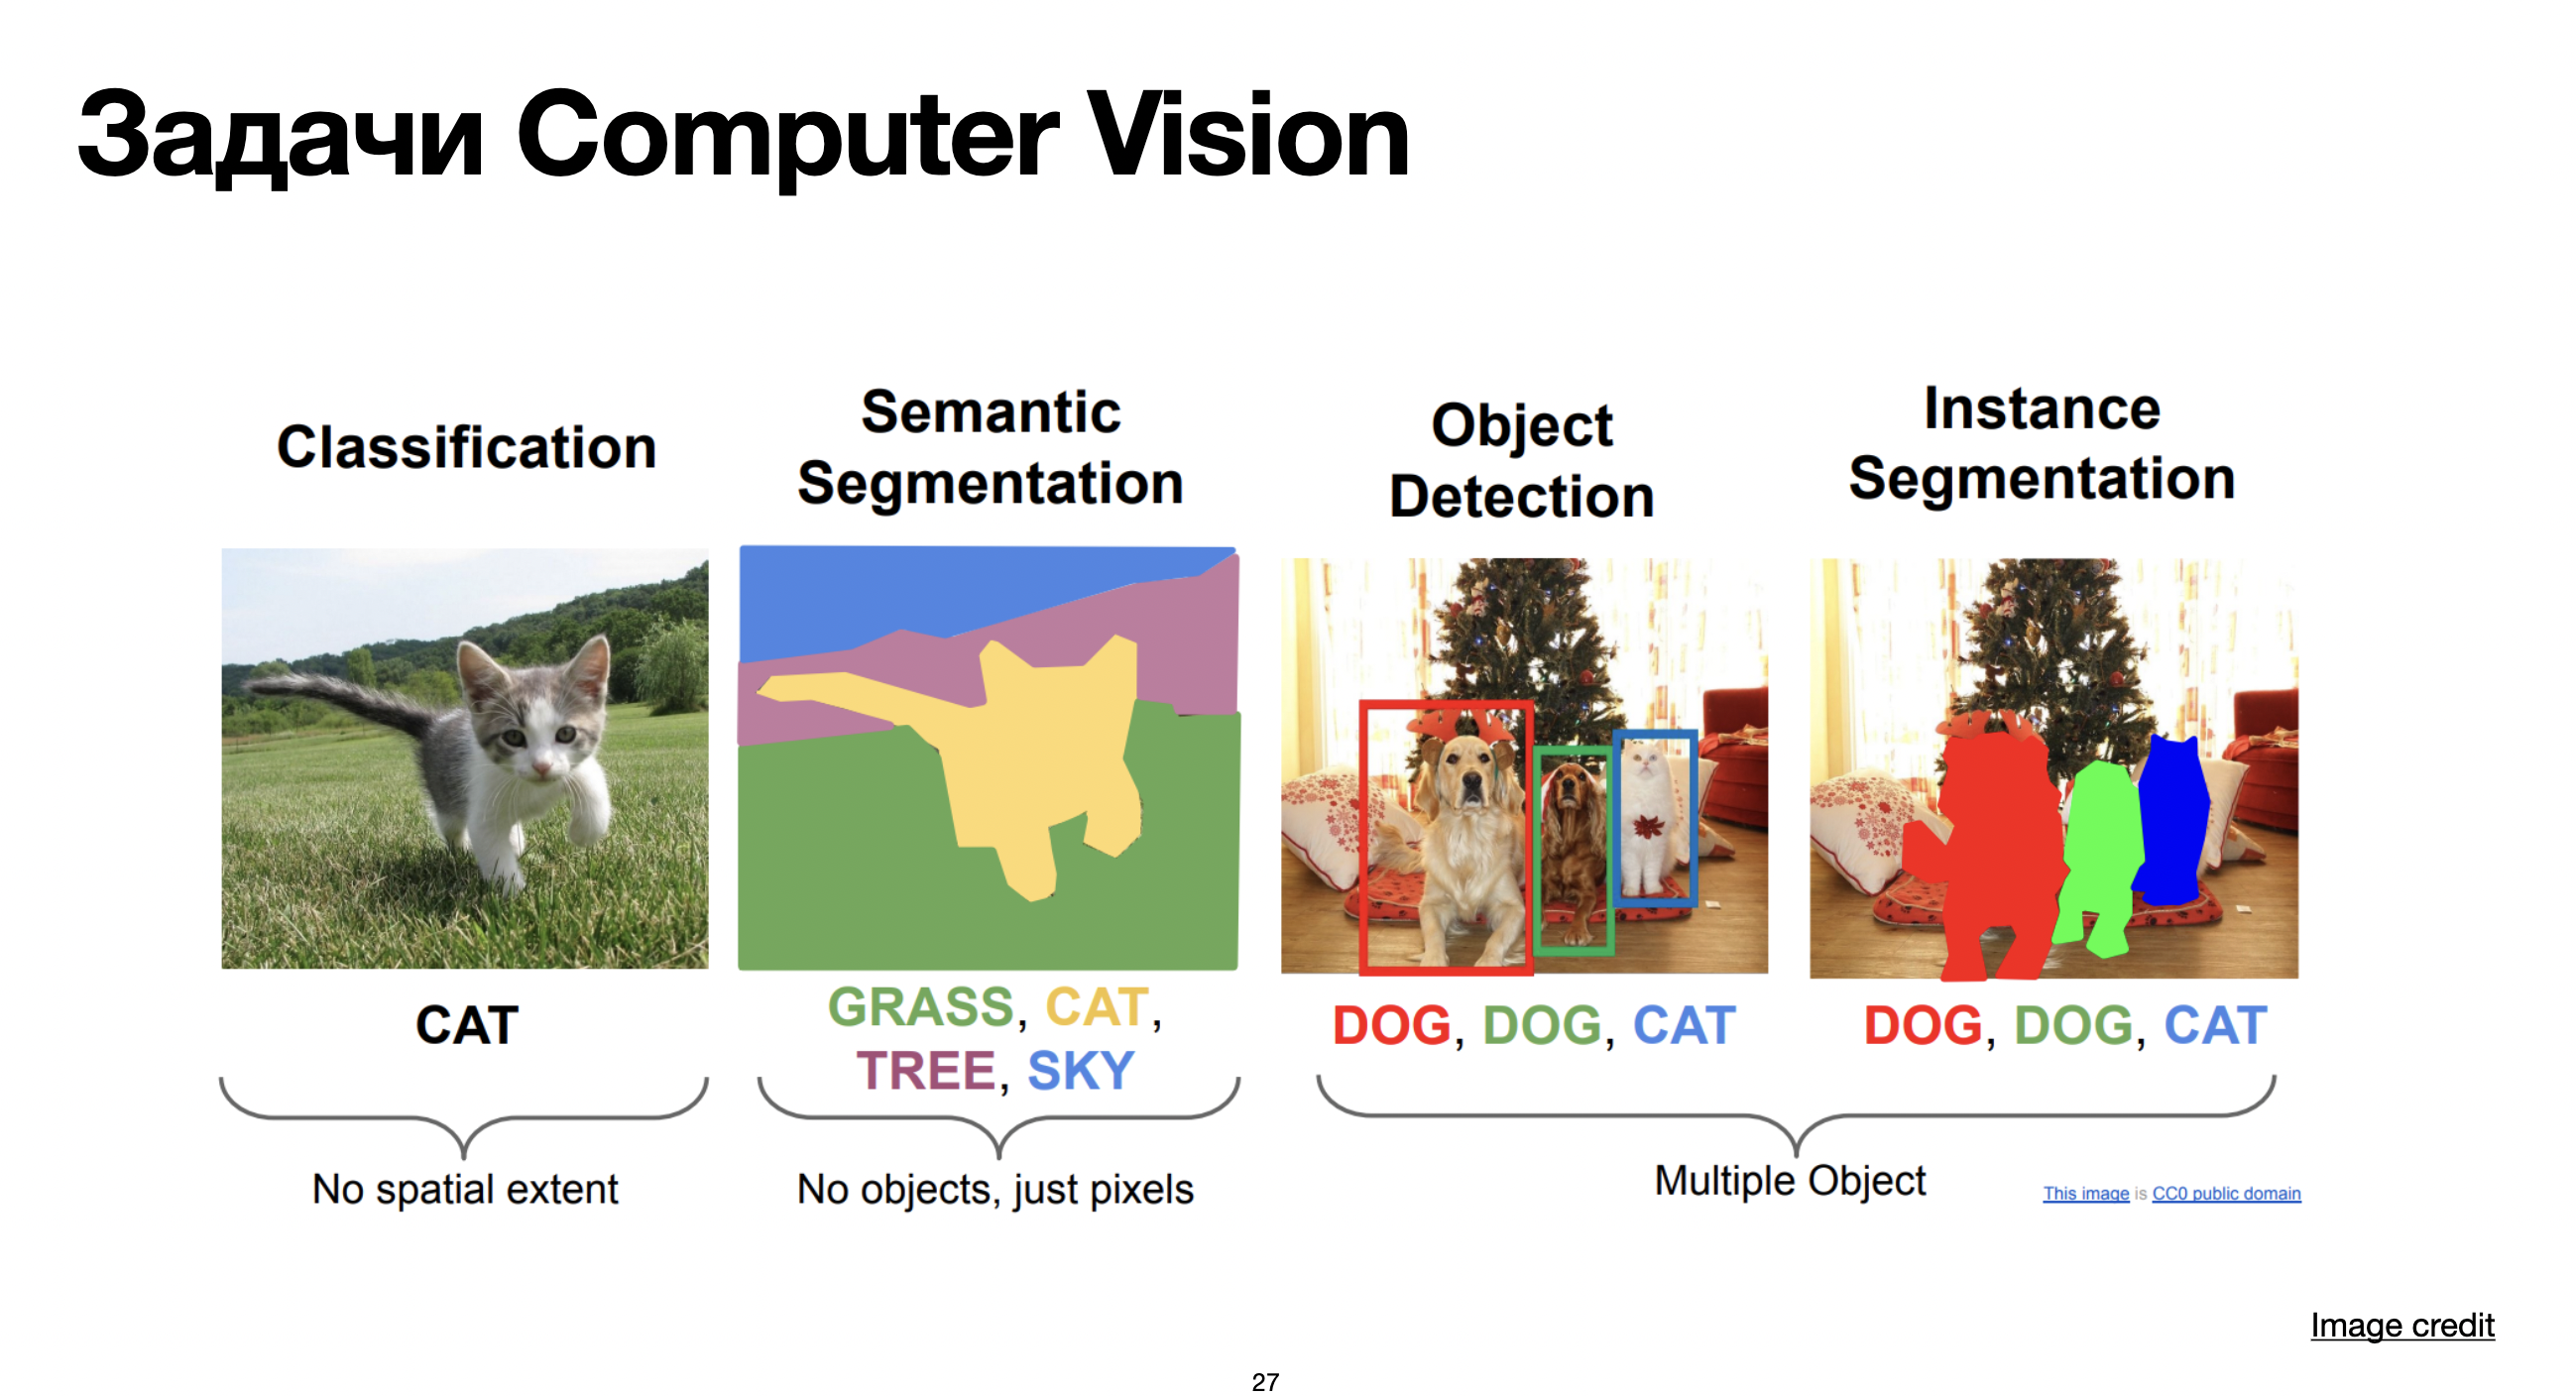

# Object Detection

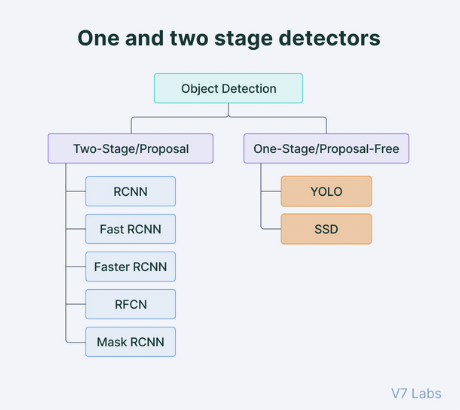

# Semantic Segmentation

Задача -- сегментировать родинки
https://www.fc.up.pt/addi/ph2%20database.html


<table><tr><td>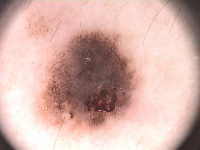</td><td>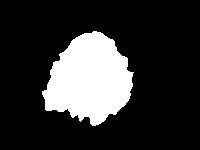</td></tr></table>


**Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникаемой в математической формуле.


In [ ]:
def dice_loss(y_pred, y_real):
    num = 2 * torch.sum( y_pred * y_real )
    # print('num', num)
    den = torch.sum( y_pred ) + torch.sum( y_real )
    # print('den', den)
    SMOOTH = 1e-8 
    # print((SMOOTH + num) / (SMOOTH + den) / (1<<16))
    res = 1 - ((SMOOTH + num) / (SMOOTH + den))
    return res 

-----------------------------------------------------------------------------------------

# U-Net

[**U-Net**](https://arxiv.org/abs/1505.04597) это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Учитывая медицинское изображение, он выводит изображение в оттенках серого, представляющее вероятность того, что каждый пиксель является интересующей областью.

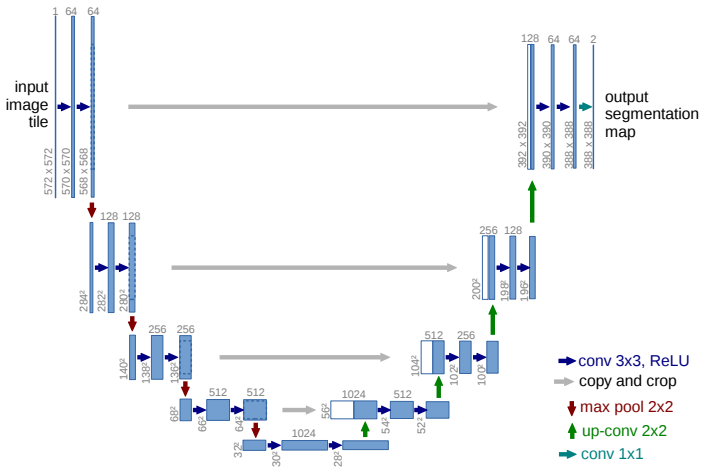

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

--2023-03-12 15:22:09--  https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/k88qukc20ljnbuo/PH2Dataset.rar [following]
--2023-03-12 15:22:10--  https://www.dropbox.com/s/raw/k88qukc20ljnbuo/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc121ca4e8824092abef6d86e7df.dl.dropboxusercontent.com/cd/0/inline/B4HvQWwSUoi3ewJNeFXDB_puUKYAGGY_NoFVTS0tcWWgGSd9NNvHiP2lekHdRemRNFfPmRWLIfprInkJQ0UHFOBov7t6zYxII4AuKLq58RU55hrAHAZJGddaVOIj15MATPfOhqKSyg3Fk0HZkk8OSokbp6NCfyv4hqmeEKuaDaTICw/file# [following]
--2023-03-12 15:22:10--  https://uc121ca4e8824092abef6d86e7df.dl.dropboxusercontent.com/cd/0/inline/B4HvQWwSUoi3ewJNeFXDB_puUKYAGGY_NoFVTS0tcWWgGSd9NNvHiP2lekHdRemRNFfPmRW

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
from torch.utils.data import DataLoader
batch_size = 6
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
class UNetBlock(nn.Module):
  def __init__(self, in_channels, out_channels, intermediate_channels=None):
        super().__init__()

        if intermediate_channels is None:
          intermediate_channels = out_channels

        self.seq = nn.Sequential(
            nn.Conv2d(in_channels, intermediate_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(intermediate_channels),
            nn.ReLU(),
            nn.Conv2d(intermediate_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

  def forward(self, x):
      return self.seq(x)

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = UNetBlock(3, 64)
        self.pool0 = nn.MaxPool2d(2)

        self.enc_conv1 = UNetBlock(64, 128)
        self.pool1 = nn.MaxPool2d(2)

        self.enc_conv2 = UNetBlock(128, 256)
        self.pool2 = nn.MaxPool2d(2)

        self.upsample2 = nn.Upsample(scale_factor=2)
        self.dec_conv2 = UNetBlock(512, 128, intermediate_channels=256)
        self.upsample3 = nn.Upsample(scale_factor=2)
        self.dec_conv3 = UNetBlock(256, 64, intermediate_channels=128)
        self.upsample4 = nn.Upsample(scale_factor=2)
        self.dec_conv4 = UNetBlock(128, 32, intermediate_channels=64)

        self.final = nn.Conv2d(32, 2, kernel_size=1)

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0( x )
        e1 = self.enc_conv1( self.pool0(e0) )
        e2 = self.enc_conv2( self.pool1( e1 ) )

        mid = self.upsample2(self.pool2( e2 ))

        # decoder
        d1 = self.dec_conv2( torch.cat( (e2, mid), dim=1 ) )
        d2 = self.dec_conv3( torch.cat( (e1, self.upsample3(d1)), dim=1 ) )
        d3 = self.dec_conv4( torch.cat( (e0, self.upsample4(d2)), dim=1 ) )
        return self.final(d3)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

unet_model = UNet().to(device)

cuda


In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded

def score_model(model, metric, data, device='cuda'):
    model.eval()  # testing mode
    model.to(device)
    with torch.no_grad():
        scores = 0
        for X_batch, Y_label in data:
            Y_pred = model( X_batch.to(device) )
            pred_class = (Y_pred[:, 1:, :, :] > 0.5) + 0
            scores += metric(pred_class, Y_label.to(device)).mean().item()

        return scores/len(data)

def plot_results(result, model_name):
  plt.figure(0)
  plt.plot(result[0], label=model_name)
  plt.title('train loss')
  plt.legend()
  plt.figure(1)
  plt.plot(result[1], label=model_name)
  plt.title('valid metric')
  plt.legend()

def train(model, opt, loss_fn, epochs, data_tr, data_val, device='cuda', with_plots=False, val_metric=None, validate_epoch_end=True, silent=True):
    X_val, Y_val = next(iter(data_val))

    model.to(device)

    train_losses = []
    val_metric = []

    for epoch in range(epochs):
        tic = time()
        if not silent:
            print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model(X_batch)

            loss = loss_fn(Y_pred[:, 1:, :, :], Y_batch) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        if not silent:
            print('loss: %f' % avg_loss)
        train_losses.append(avg_loss.item())

        # show intermediate results
        if with_plots:
            model.eval()  # testing mode
            with torch.no_grad():
                Y_hat = model(X_val.to(device))
                Y_hat = Y_hat.detach().cpu() # detach and put into cpu

                # Visualize tools
                clear_output(wait=True)
                for k in range(6):
                    plt.subplot(2, 6, k+1)
                    plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
                    plt.title('Real')
                    plt.axis('off')

                    plt.subplot(2, 6, k+7)
                    plt.imshow(Y_hat[k, 0], cmap='gray')
                    plt.title('Output')
                    plt.axis('off')
                plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
                plt.show()
        if validate_epoch_end:
            avg_metric = score_model(model, iou_pytorch, data_val)
            val_metric.append(avg_metric)
    return train_losses, val_metric

CPU times: user 2min 44s, sys: 1.14 s, total: 2min 45s
Wall time: 2min 53s


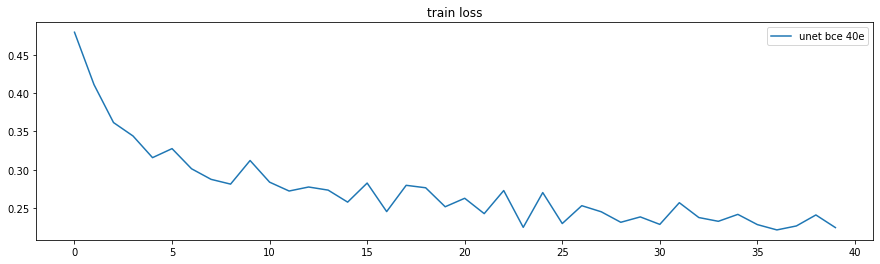

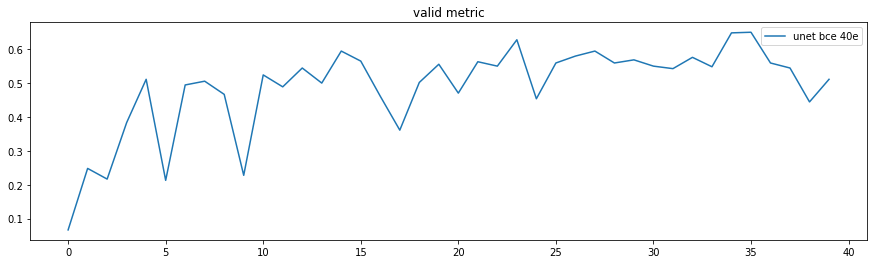

In [ ]:
%%time

relu = nn.ReLU()
# на самом деле, bce лосс
def bce_loss(y_pred, y_real):
    # hand made nn.BCELoss
    assert y_pred.shape == y_real.shape
    return torch.mean(relu(y_pred) - y_real * y_pred + torch.log( 1 + torch.exp(-torch.abs(y_pred)) ))

unet_bce_result = train(unet_model, torch.optim.Adam(unet_model.parameters()), bce_loss, 40, data_tr, data_val)
plot_results(unet_bce_result, 'unet bce 40e')

In [ ]:
def get_segmentation_example(model, data_val):
    X_val, Y_val = next(iter(data_val))

    model.eval()
    with torch.no_grad():
        Y_hat = model(X_val.to(device))
        Y_hat = Y_hat.detach().cpu() # detach and put into cpu

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.show()

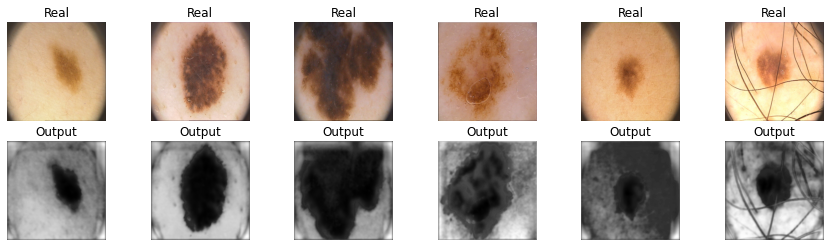

In [ ]:
get_segmentation_example(unet_model, data_val)

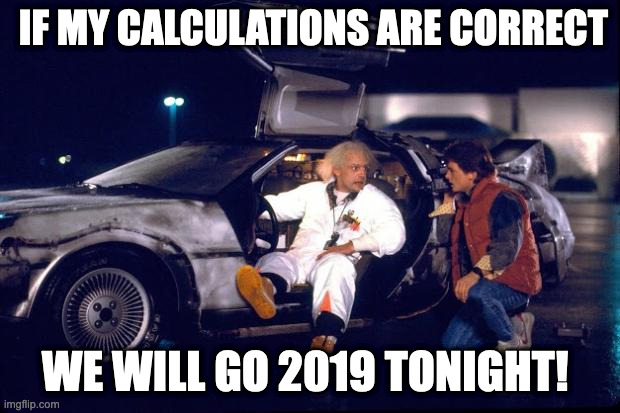

Неплохие скорее обзорные семы из 2019

* [Ноутбук Захаркина Ильи](https://colab.research.google.com/drive/17iJcJkegjb8fRCpDD9j0M6ua7pLlOzpL?usp=sharing)
* [Запись сема Захаркина](https://www.youtube.com/watch?v=XSPYe4-y4HE)
* [Семантическая сегментация от Татьяны Гайнцевой](https://www.youtube.com/watch?v=tIqndofykgc) (в описании видоса есть ссылки на другие части про сегментацию)


